# Assignment 3

## Part 1

The goal of this part of the assignment is to provide you with practice and experience in some basic data exploration and hypothesis testing with Python. You will work with data from the “HUE bedtime procrastination study”. A cleaned version of the data is available on Canvas (`hue_week_3.csv`), as well as another file that contains data from the post-study questionnaire that participants filled out at the end of the study (`hue_questionnaire.csv`). This file contains the following information:

| Column | Description |
-----------------------|--------------------------------------------|
| `gender`          | 1 = male, 2 = female |
| `age`           | Numeric age value | 
| `chronotype`      |    Single item (7-point scale), do you consider yourself more of a <br> morning (1) or an evening person? (7) |
| `bp_scale` | Dutch version of the Bedtime Procrastination Scale |
| `motivation` | Questions pertaining to personality traits related to procrastination. <br> Single item (7-point scale), how motivated were you to go to bed on <br> time each night? (1 = not motivated, 7 = very motivated) |
| `daytime_sleepiness` | Dutch translation of the Epworth Sleepiness Scale <br> (4-point scale from 0-3; 8 questions, values summed) |
| `self_reported_effectiveness` | Single item (7-point scale), <br> do you feel more rested since the intervention |

In this part of the assignment, you will use Python to examine the post-questionnaire data in relation to the HUE data file, visualize trends and relationships, look for correlations between factors, test for significant differences between groups and build a regression model to predict bedtime delay. In order to perform the analyses, a number of transformations on the data still need to be done.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import datetime
import sys
from io import StringIO


pd.options.display.max_rows = 20

## Exercise 1 (20 points)
Implement the following steps in Python:

<ul>
<li>
    Read the HUE data file and the questionnaire data file into two separate pandas DataFrames.
<br></li>
<li>
    Create a new DataFrame that contains the following Series:
    
| Column | Description |
-----------------------|--------------------------------------------|
| `ID` | Participant ID |
| `group` | Participant group (1 for experimental, 0 for control) |
| `delay_nights` | The number of nights the participant delayed their bedtime (range: 0-12) |
| `delay_time` | The mean time in seconds a participant delayed their bedtime <br> (total delay in seconds, divided by the number of observations <br> measured for each individual, rounded to nearest second) |
| `sleep_time` | The mean time in seconds of a participant (rounded to nearest second) |
    
    
<br></li>
<li>
    Set the index of this new DataFrame to `ID`. Note that there should only be a single row per participant ID.    
<br></li>
<li>
    Fill this new DataFrame by transforming data from the DataFrame about participants' bedtimes (from the HUE data file).
<br></li>
<li>
    Merge this new DataFrame with the post-questionnaire data and store the resulting DataFrame in a new variable. Perform this merging operation of the two DataFrames in such a way that the resulting Data Frame only contains IDs that were present in both datasets.
<br></li>
<li>
    Remove the rows that have NaN values in this merged DataFrame.
</li>
</ul> 

In [2]:
sleepdatafile   = 'hue_week_3.csv'
surveydatafile  = 'hue_questionnaire.csv'

In [3]:
def read_data(sleepdatafile, surveydatafile):
# YOUR CODE HERE
    import datetime as dt
    import statistics 
    colnames = ['ID', 'group', 'delay_nights', 'delay_time', 'sleep_time']
    sleep = pd.read_csv(sleepdatafile, sep = ',', encoding ='utf_8')
    survey = pd.read_csv(surveydatafile, sep = ',', encoding ='utf_8')
    
    def date_from_time(datetime_str):
        today = dt.date.today()
        tomorrow = today + dt.timedelta(days=1)
        time = dt.datetime.strptime(datetime_str, '%H:%M').time()
        if time < dt.time(16,0,0): #morning next date
            return dt.datetime.combine(tomorrow, time)
        else:
            return dt.datetime.combine(today, time)

    def gth_(x, y):
        if is_nan((x, y)):
            return False
        return date_from_time(x) > date_from_time(y)

    def diff(a):
        x, y = a[1], a[0]
        return (date_from_time(x) - date_from_time(y)).total_seconds()

    def is_nan(x):
        return x[0] != x[0] or x[1] != x[1]

    def mean(l):
        if l:
            return round(statistics.mean(l))
        
    
    sleep = pd.read_csv(sleepdatafile, sep = ',', encoding ='utf_8')
    col_names = sleep.columns
    rows = []
    index = []
    for _, row in sleep.iterrows():
        intended = [x for (y, x) in zip(col_names, row) if "Intended Bedtime" in y]
        actual = [x for (y, x) in zip(col_names, row) if "Actual Bedtime" in y]
        rise_time = [x for (y, x) in zip(col_names, row) if "Rise Time" in y]

        delayed_nights = list(filter(lambda x : gth_(x[1], x[0]), zip(intended, actual)))
        delay_time = mean(list(map(lambda x : diff(x), delayed_nights)))
        sleep_time = mean(list(map(diff, filter(lambda x : not is_nan(x), zip(actual, rise_time[1:])))))


        row_ = [row['Condition'], len(delayed_nights), delay_time, sleep_time]
        rows.append(row_)
        index.append(row['ID'])


    df_ = pd.DataFrame(rows, columns=['group', 'delay_nights', 'delay_time', 'sleep_time'], index=index) 
    combined = survey.merge(df_, left_index=True, right_index=True, suffixes=(False, False)).dropna()

    return combined

    
# YOUR CODE ENDS HERE

In [4]:
mergedDfNoNan = read_data(sleepdatafile, surveydatafile)
mergedDfNoNan


,ID,gender,age,chronotype,bp_scale,motivation,daytime_sleepiness,self_reported_effectiveness,group,delay_nights,delay_time,sleep_time
1,2,2,25,5,5.22,4,21,2,0,10,6030.0,31222.0
2,4,2,30,1,6.67,5,14,5,0,7,2494.0,27880.0
4,6,1,27,6,5.11,6,14,3,1,7,4149.0,30345.0
5,7,1,24,6,4.11,5,8,5,1,9,2620.0,32267.0
6,8,2,24,6,3.67,4,10,3,0,7,5417.0,29925.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36,52,1,18,7,5.56,3,11,3,0,10,2508.0,32100.0
37,53,2,43,6,4.67,6,16,5,0,9,4613.0,25600.0
38,55,1,26,4,5.00,2,15,1,0,6,3770.0,29070.0
39,58,1,35,7,6.33,6,12,2,1,4,3855.0,29100.0


## Exercise 2 (5 points)
Use the `scipy.stats` package and, respectively, the Pearson correlation test and the Kendall rank correlation test, to calculate the following correlation coefficients:
<br></li>
<li>
    the Pearson correlation coefficient between bedtime procrastination scale (`bp_scale`, a personality trait) and mean time spent delaying bedtime,    
<br></li>
<li>
    the Kendall rank correlation coefficient between age and mean time spent delaying bedtime,
<br></li>
<li>
    the Pearson correlation coefficient between mean time spent delaying bedtime and daytime sleepiness.
</li>
</ul> 

Save them into the variables `r1`, `tau`, `r2`.

In [5]:
def calculate_correlations(mergedDfNoNan):
# YOUR CODE HERE
    from scipy.stats import pearsonr, kendalltau
    r1 = pearsonr(mergedDfNoNan['bp_scale'], mergedDfNoNan['delay_time'])
    tau = kendalltau(mergedDfNoNan['age'], mergedDfNoNan['delay_time'])
    r2 = pearsonr(mergedDfNoNan['daytime_sleepiness'], mergedDfNoNan['delay_time'])
    return (r1[0], r1[1], tau[0], tau[1], r2[0], r2[1])
# YOUR CODE ENDS HERE

In [6]:
r1, pvalue1, tau, pvalue2, r2, pvalue3 = calculate_correlations(mergedDfNoNan)

statistics = [r1,tau,r2]
pvalues = [pvalue1, pvalue2, pvalue3]

print("Correlation tests:")
for (statistic, pvalue) in zip(statistics, pvalues):
    print('The value of the test statistic is:',statistic)
    print('The p-value is:', pvalue,'\n')


Correlation tests:
The value of the test statistic is: 0.016032490387569452
The p-value is: 0.9317826689344718 

The value of the test statistic is: -0.16177037282670842
The p-value is: 0.20706052653999363 

The value of the test statistic is: -0.21357283119565562
The p-value is: 0.24865267194194043 



## Exercise 3 (15 points)
Use the `scipy.stats` package to determine whether there are significant differences (at 5\% significance level) between the experimental group and the control group in terms of:
<br></li>
<li>
    the number of nights participants delayed their bedtime,    
<br></li>
<li>
    the time participants spent in bed each night,
<br></li>
<li>
    the mean time participants spent delaying their bedtime.
</li>
</ul> 

Use the t-test or the Wilcoxon rank-sum test to reach a conclusion and use knowledge gained in the courses Statistics and Statistical Data Analysis to determine which statistical test is appropriate. Save the conclusions - either the string 'significant difference' or 'no significant difference' - into the variables `dif1`, `dif2`, `dif3`.

\* Note that in the final assignment you are expected to explicitly motivate the choice of an appropriate test, in this exercise you do not have to.

In [7]:
# Shapiro-Wilks test for normality

# Null hypothesis: Population is normally distributed
# If p-value < 0.05 then H0 is rejected and evidence that the data are not normally distributed

shapiro_dn_1 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_nights'])
shapiro_dn_0 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_nights'])

print ("Shapiro Delay_Nights 1:", shapiro_dn_1)
print ("P-value = 0.382 > 0.05, therefore cannot reject H0 of normality \n")
print ("Shapiro Delay_Nights 0:", shapiro_dn_0)
print ("P-value = 0.179 > 0.05, therefore cannot reject H0 of normality \n")
print ("Conclude that Delay_Night data sets NORMAL\n")

shapiro_st_1 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['sleep_time'])
shapiro_st_0 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['sleep_time'])

print ("Shapiro Sleep_Time 1:", shapiro_st_1)
print ("P-value = 0.420 > 0.05, therefore cannot reject H0 of normality \n")
print ("Shapiro Sleep_Time 0:", shapiro_st_0)
print ("P-value = 0.884 > 0.05, therefore cannot reject H0 of normality \n")
print ("Conclude that Sleep_Time data sets NORMAL\n")

shapiro_dt_1 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_time'])
shapiro_dt_0 = stats.shapiro(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_time'])

print ("Shapiro Delay_Time 1:", shapiro_dt_1)
print ("P-value = 0.157 > 0.05, therefore cannot reject H0 of normality \n")
print ("Shapiro Delay_Time 0:", shapiro_dt_0) 
print ("P-value = 0.049 < 0.05, therefore REJECT H0 of normality \n")
print ("Conclude that Delay_Time data sets NOT NORMAL\n")

Shapiro Delay_Nights 1: (0.9400081038475037, 0.38247203826904297)
P-value = 0.382 > 0.05, therefore cannot reject H0 of normality 

Shapiro Delay_Nights 0: (0.9216054677963257, 0.1790165901184082)
P-value = 0.179 > 0.05, therefore cannot reject H0 of normality 

Conclude that Delay_Night data sets NORMAL

Shapiro Sleep_Time 1: (0.9428483843803406, 0.419540137052536)
P-value = 0.420 > 0.05, therefore cannot reject H0 of normality 

Shapiro Sleep_Time 0: (0.972995936870575, 0.8844887018203735)
P-value = 0.884 > 0.05, therefore cannot reject H0 of normality 

Conclude that Sleep_Time data sets NORMAL

Shapiro Delay_Time 1: (0.9141794443130493, 0.15693551301956177)
P-value = 0.157 > 0.05, therefore cannot reject H0 of normality 

Shapiro Delay_Time 0: (0.8864372372627258, 0.048940468579530716)
P-value = 0.049 < 0.05, therefore REJECT H0 of normality 

Conclude that Delay_Time data sets NOT NORMAL



In [8]:
# Levene test for equality of variances
# Null hypothesis: All input samples are from populations with equal variances.
# If p-value < 0.05 then H0 is rejected and evidence that the data do not have equal variances

levene_dn = stats.levene(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_nights'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_nights'])

print ("Levene Delay_Nights:", levene_dn)
print ("P-value = 0.242 > 0.05, therefore cannot reject H0 of equal variances")
print ("Conclude that Delay_Night Group 0 and 1 conform to the variance criterion \n")

levene_st = stats.levene(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['sleep_time'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['sleep_time'])

print ("Levene Sleep_Time:", levene_st)
print ("P-value = 0.191 > 0.05, therefore cannot reject H0 of equal variances")
print ("Conclude that Sleep_Time Group 0 and 1 conform to the variance criterion \n")

levene_dt = stats.levene(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_time'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_time'])

print ("Levene Delay_Time:", levene_dt)
print ("P-value = 0.732 > 0.05, therefore cannot reject H0 of equal variances")
print ("Conclude that Delay_Time Group 0 and 1 conform to the variance criterion")


Levene Delay_Nights: LeveneResult(statistic=1.4242952630049401, pvalue=0.24236989965220507)
P-value = 0.242 > 0.05, therefore cannot reject H0 of equal variances
Conclude that Delay_Night Group 0 and 1 conform to the variance criterion 

Levene Sleep_Time: LeveneResult(statistic=1.7931981705231588, pvalue=0.19093921792583313)
P-value = 0.191 > 0.05, therefore cannot reject H0 of equal variances
Conclude that Sleep_Time Group 0 and 1 conform to the variance criterion 

Levene Delay_Time: LeveneResult(statistic=0.11915512521670593, pvalue=0.7324438987997046)
P-value = 0.732 > 0.05, therefore cannot reject H0 of equal variances
Conclude that Delay_Time Group 0 and 1 conform to the variance criterion


In [9]:
from scipy.stats import ttest_ind, ranksums

def perform_tests(mergedDfNoNan):
    dif1 = ttest_ind(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_nights'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_nights'])
    # For Delay_Nights we select T-test as the data is normally distributed and variances are equal
    print(dif1)
    print('''pvalue = 0.777 > 0.05: At the 5% significance level cannot reject H0 of equal average delay in bedtime \n''')
    
    dif2 = ttest_ind(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['sleep_time'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['sleep_time'])
    # For Sleep_Time we select T-test as the data is normally distributed and variances are equal
    print(dif2)
    print('''pvalue = 0.583 > 0.05: At the 5% significance level cannot reject H0 of equal average time spent in bed \n''')
    
    dif3 = ranksums(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_time'], mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_time'])
    # For Delay_Time we select the Wilcox Rank-Sum Test as the data is not normally distributed and variance of groups is equal
    print(dif3)
    print('''pvalue = 0.155 > 0.05: At the 5% significance level cannot reject H0 that the mean time participants spent 
    delaying their bedtime is drawn from the same distribution \n''')
    
    dif1 = 'no significant difference' 
    dif2 = 'no significant difference'
    dif3 = 'no significant difference'
    
    return dif1, dif2, dif3
    
# YOUR CODE ENDS HERE

In [10]:
dif1, dif2, dif3 = perform_tests(mergedDfNoNan) 

print('The number of nights participants delayed their bedtime:', dif1)
print('The time participants spent in bed each night:', dif2)
print('The mean time participants spent delaying their bedtime:', dif3)


Ttest_indResult(statistic=-0.28576294305585587, pvalue=0.7770909954390499)
pvalue = 0.777 > 0.05: At the 5% significance level cannot reject H0 of equal average delay in bedtime 

Ttest_indResult(statistic=-0.5551756757553626, pvalue=0.5830320043003667)
pvalue = 0.583 > 0.05: At the 5% significance level cannot reject H0 of equal average time spent in bed 

RanksumsResult(statistic=-1.4230249470757705, pvalue=0.15472892348537853)
pvalue = 0.155 > 0.05: At the 5% significance level cannot reject H0 that the mean time participants spent 
    delaying their bedtime is drawn from the same distribution 

The number of nights participants delayed their bedtime: no significant difference
The time participants spent in bed each night: no significant difference
The mean time participants spent delaying their bedtime: no significant difference


## Exercise 4 (15 points)
Use `statsmodels.api` to build a regression model for `delay_time` on the predictors `age`, `chronotype` and `bp_scale`. Return the coefficients of the model, and the conclusion whether the model is significant by using the string 'significant' or 'not significant'.

\* Convince yourself that the basic diagnostics for this model are ok. Here not, but in the final assignment you are expected to explicitly check the diagnostics.

In [11]:
def regression_analysis(mergedDfNoNan):
# YOUR CODE HERE
    import statsmodels.formula.api as sm

    results = sm.ols(formula='delay_time ~ age + chronotype + bp_scale', data=mergedDfNoNan).fit()
    # Prob (F-statistic) (null hypothesis under this is “all the regression coefficients are equal to zero”) 
    # is small, so model is significant, Prob(Omnibus) is 2.0somethind, so it seems fine
    return([results.params[1:][0], results.params[1:][1], results.params[1:][2]] , "significant")

# YOUR CODE ENDS HERE

In [12]:
parameters, significant = regression_analysis(mergedDfNoNan)

print('The parameters of the model are:')
print(parameters)
print('\nThe model is', significant)


The parameters of the model are:
[-18.826011975454982, 110.94284828989167, -99.24964472165057]

The model is significant


## Exercise 5 (15 points)
Create three distinct, meaningful, well-crafted visualizations that either provide insight into the data, or help support your conclusions. This means creating three different kinds of plots (not three boxplots, or three scatterplots for example). Interpret and discuss your findings.

Text(0.5, 1, 'Delayed bedtime vs. Sleepiness Scale (r2)')

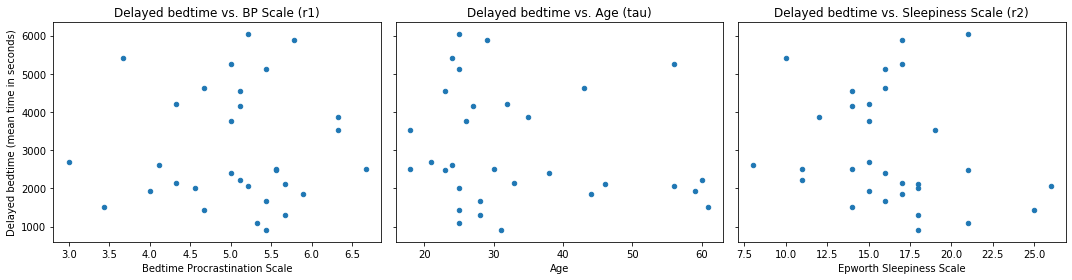

In [13]:
# Plot 1
# YOUR CODE HERE

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [15,4], sharey = True)
fig.tight_layout()
fig.set_tight_layout(True)
mergedDfNoNan.plot(x='bp_scale', y = 'delay_time', kind = 'scatter', ax = ax0, fontsize = 10)
xlab = ax0.set_xlabel('Bedtime Procrastination Scale')
ylab = ax0.set_ylabel('Delayed bedtime (mean time in seconds)')
ax0.set_title('Delayed bedtime vs. BP Scale (r1)')

mergedDfNoNan.plot(x = 'age', y = 'delay_time', kind = 'scatter', ax = ax1,  fontsize = 10)
xlab = ax1.set_xlabel('Age')
ylab = ax1.set_ylabel('Delayed bedtime (mean time in seconds)')
ax1.set_title('Delayed bedtime vs. Age (tau)')

mergedDfNoNan.plot(x = 'daytime_sleepiness', y = 'delay_time', kind = 'scatter', ax = ax2,  fontsize = 10)
xlab = ax2.set_xlabel('Epworth Sleepiness Scale')
ylab = ax2.set_ylabel('Delayed bedtime (mean time in seconds)')
ax2.set_title('Delayed bedtime vs. Sleepiness Scale (r2)')

# YOUR CODE ENDS HERE

### Scatterplot interpretation

The scatterplots support the fairly weak correlation results obtained in the correlation tests.<br>
In fact, the correlation is so weak, that without the test results it would be difficult to infer correlation from the scatterplots alone. <br>
The first scatterplot (representing r1) has a weak positive correlation. <br>
The Pearson correlation coefficient was measured at 0.016. <br>
What this means is that as the score on the Bedtime Procrastination Scale increases, so does the delay in bedtime.

The second (tau) and third (r2) scatterplots both have a weak negative correlation. <br>
The tau statistic was measured at -0.162. <br>
As Age increases, the delay in bedtime decreases.

In the third scatterplot (r2) the Pearson correlation coefficient was measured at -0.214. <br>
As the score on the Epworth Sleepiness Scale increases, the delay in bedtime decreases.

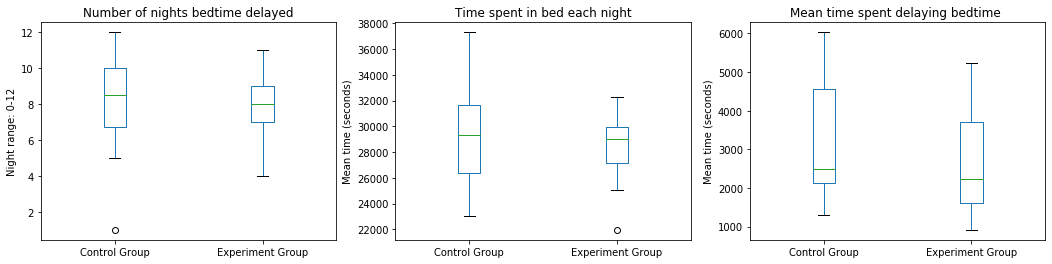

In [14]:
# Plot 2
# YOUR CODE HERE
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [18, 4])
# Delay Nights
dn_0 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_nights'], name = "Control Group")
dn_1 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_nights'], name = "Experiment Group")

dnDf = pd.concat([dn_0, dn_1], axis = 1)
dnDf.boxplot(column = ["Control Group", "Experiment Group"], grid = False, ax = ax0)
ax0.set_title("Number of nights bedtime delayed")
ylab = ax0.set_ylabel('Night range: 0-12')

# Sleep Time
st_0 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['sleep_time'], name = "Control Group")
st_1 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['sleep_time'], name = "Experiment Group")

stDf = pd.concat([st_0, st_1], axis = 1)
stDf.boxplot(column = ["Control Group", "Experiment Group"], grid = False, ax = ax1)
ax1.set_title("Time spent in bed each night")
ylab = ax1.set_ylabel('Mean time (seconds)')

# Delay Time
dt_0 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(0)]['delay_time'], name = "Control Group")
dt_1 = pd.Series(mergedDfNoNan[mergedDfNoNan.group.eq(1)]['delay_time'], name = "Experiment Group")

dtDf = pd.concat([dt_0, dt_1], axis = 1)
dtDf.boxplot(column = ["Control Group", "Experiment Group"], grid = False, ax = ax2)
ax2.set_title("Mean time spent delaying bedtime ")
ylab = ax2.set_ylabel('Mean time (seconds)')

# YOUR CODE ENDS HERE

###  Boxplot interpretation

<b>Number of nights bedtime delayed:</b> <br>
The median number of nights that sleep is delayed in both groups is around 8. <br>
There is slightly greater variability in the number of nights that bedtime is delayed in the Control Group, with one outlier.

<b>Time spent in bed each night:</b> <br>
The Control Group distribution is very wide with a great deal of variability in mean time spent in bed. <br>
The Experiment Group looks to be more similar with less variability. <br>
The median is pretty similar between groups between 28000 - 30000 seconds.

<b>Mean time spent delaying bedtime:</b> <br>
The Control Group distribution again shows a high level of variability and the Experiment Group as well. <br>
The uncentred median and irregular length of the whiskers suggests more right skewness in these distributions.

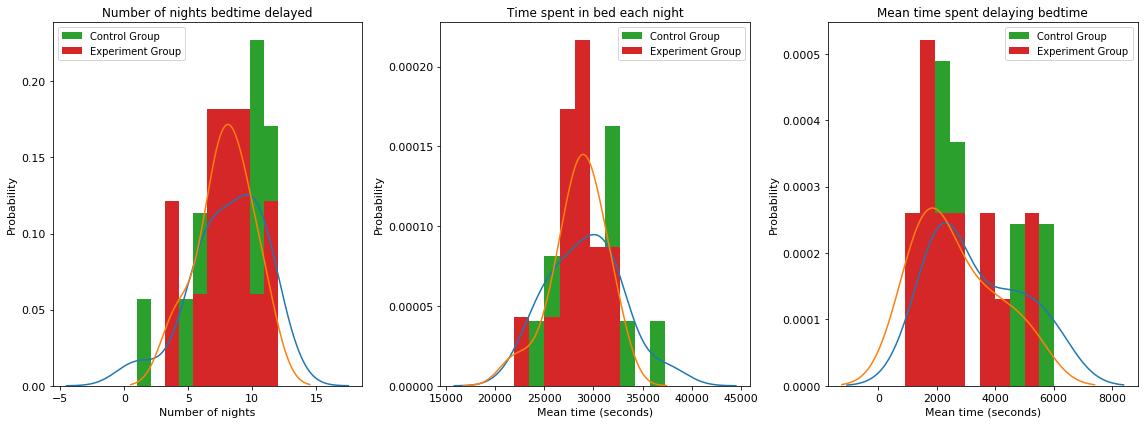

In [15]:
# Plot 3
# YOUR CODE HERE
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [16, 6])
fig.tight_layout()
fig.set_tight_layout(True)

#Delay Nights
dnDf = pd.concat([dn_0, dn_1], axis = 1)

dnDf.plot.kde(ax=ax0, legend=False, title= "Number of nights bedtime delayed", fontsize = 11)
dnDf.plot.hist(density=True, ax=ax0)
ylab = ax0.set_ylabel('Probability', fontsize = 11)
xlab = ax0.set_xlabel('Number of nights', fontsize = 11)

# Sleep Time
stDf = pd.concat([st_0, st_1], axis = 1)

stDf.plot.kde(ax=ax1, legend=False, title='Time spent in bed each night', fontsize = 11)
stDf.plot.hist(density=True, ax=ax1)
ylab = ax1.set_ylabel('Probability', fontsize = 11)
xlab = ax1.set_xlabel('Mean time (seconds)', fontsize = 11)

# Delay Time
dtDf = pd.concat([dt_0, dt_1], axis = 1)

dtDf.plot.kde(ax=ax2, legend=False, title='Mean time spent delaying bedtime', fontsize = 11)
dtDf.plot.hist(density=True, ax=ax2)
ylab = ax2.set_ylabel('Probability', fontsize = 11)
xlab = ax2.set_xlabel('Mean time (seconds)', fontsize = 11)
# YOUR CODE ENDS HERE

### Histogram interpretation

Given the small sample sizes, caution is taken in making inferences about the shape of the population being sampled from these histograms alone. <br>
However, given we have the results of the Shapiro-Wilks test for normality, we can see that these
histograms support those results. <br>

The first two histograms from the right appear to show more symmetry and normality. In particular the Experiment Group. <br>
While the far right histogram is right skewed. This is further motivates the choice of the Wilcoxon Rank-Sum test to measure these distributions.  

# Part 2
The goal of this part of the assignment is to provide you with practice in implementing MapReduce in Python. Using the `map_reduce_hue.csv` dataset, you will implement two simple MapReduce algorithms.

<a href="https://towardsdatascience.com/a-beginners-introduction-into-mapreduce-2c912bb5e6ac">First read this webpage!</a>

In the ideal situation, we would have access to multiple nodes in the cloud to test our MapReduce functions. Instead, we are going to simulate such an environment in this notebook. We are going to feed the Map function a line of the file in each call (as if this is running on a node in the cloud). The Map function will print the result of the computation to the standard output. When all Map function have processed all lines of the file, the Reduce function is going to collect the output of the Map functions (all the intermediate results that were printed). We do this line by line as well as if the output of a Map function is sent to a Reduce function directly. The Reduce function will then transform the intermediate results to obtain the final answer that one wants to compute. 

Since the Map function is using the `print()` function to communicate to the Reduce function, we use a smart trick! We store the standard output in a variable, and replace it by a variable. Whenever the Map function using the `print()` function, it is added in a string to the variable. After all Map functions are finished, we have collected all the output and change back to the original standard output. Now, the reduce function can use the variable to process the output of the Map functions. Note that since the Reduce function is fed line by line, the function might need to use global variables instead of local variable to store the information.

## Exercise 6 (15 points)
Write a MapReduce algorithm that counts and outputs the total number of times the fitness value is strictly higher than 50. The expected output is a single integer. In this case, the Map function should print relevant information related to the line that be used by the Reduce function. The Reduce function should read all these values, and print the total count. In this case, it might be necessary to have a global variable `totalCount`, which indicates the current count of the number of relevant lines.

In [ ]:
def mapper1(line):
# YOUR CODE HERE
    values = line.split(',')
    for index,value in enumerate(values):
        if index == 5:
            print ('\t{}\t{}'.format(value, 1))
# YOUR CODE ENDS HERE

In [ ]:
def reducer1(line):
# YOUR CODE HERE
    global totalCount
    if not line:
        print(totalCount)
        totalCount = 0
    else:
        line = line.strip()
        listOfElements = line.split('\t')
        listOfElements = [int(element) if element.isdigit() else float(element) for element in listOfElements if element]
        totalCount += len([x for x in listOfElements if x > 50])        
# YOUR CODE ENDS HERE

In [ ]:
def mapreduce1(data):    
    old_stdout = sys.stdout
    mystdout = StringIO()
    sys.stdout = mystdout

    with open(data) as file:
        for index, line in enumerate(file):
            if index == 0:
                continue
            line = line.strip()
            mapper1(line)
        mapper1(',,,,,,,')
        
        sys.stdout = old_stdout
        mapper_lines = mystdout.getvalue().split("\n")
        mystdout.close()

        for index, line in enumerate(sorted(mapper_lines)):
            if index == 0:
                continue
            reducer1(line)
        reducer1('')

In [ ]:
totalCount = 0
mapreduce1('map_reduce_hue.csv')


In [ ]:
totalCount

## Exercise 7 (15 points)
Write a MapReduce algorithm that calculates the mean fitness per participant. Do not use any statistical packages to calculate the mean. The expected output is one line per participant, containing the participants ID and the mean of his or her fitness, separated by a tab ("\t"). The outputted lines do not have to be sorted. 

The Map function in this case is more complicated than in the previous case. Think about what information the Map function should give the Reduce function. In this case, it is necessary to have at least the variable `currentID` (indicating which ID you are processing) as global variable

In [ ]:
def mapper2(line):
# YOUR CODE HERE
    global currentID
    user_index = 1
    finitness_index = 5
    values = line.split(',')
    if ",,,," not in line:
        print ('{}\t{}'.format(values[user_index].strip("\""), values[finitness_index]))
    else:
        currentID = ''
        
# YOUR CODE ENDS HERE

In [ ]:
def reducer2(line):
# YOUR CODE HERE
    global currentID, values
    
    def mean(l):
        return sum(l)/len(l)
    
    if not line:
        print(mean(values))
        currentID=''
        values=[]
    else:
        line = line.strip("")
        elements = line.split('\t')
        nextID, value = elements[0], elements[1]
        if currentID == nextID:
            values.append(float(value))
        else:
            if currentID:
                print("{}\t{}".format(currentID, mean(values)))
            values = [float(value)]
            currentID = nextID.strip()
            
    
# YOUR CODE ENDS HERE

In [ ]:
def mapreduce2(data):    
    old_stdout = sys.stdout
    mystdout = StringIO()
    sys.stdout = mystdout

    with open(data) as file:
        for index, line in enumerate(file):
            if index == 0:
                continue
            line = line.strip()
            mapper2(line)
        mapper2(',,,,,,,')
        
        sys.stdout = old_stdout
        mapper_lines = mystdout.getvalue().split("\n")
        mystdout.close()

        for index, line in enumerate(sorted(mapper_lines)):
            if index == 0:
                continue
            reducer2(line)
        reducer2('')

In [ ]:
currentID = ''
mapreduce2('map_reduce_hue.csv')
